In [53]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-12-02 08:52:08,455: Credentials are already in use. The existing account in the session will be replaced.


In [54]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import *
import matplotlib.pyplot as plt
%matplotlib inline
from qiskit.visualization import plot_histogram

In [55]:
from qiskit.quantum_info import*


In [56]:
qr = QuantumRegister(3)    
cr1 = ClassicalRegister(1)
cr2 = ClassicalRegister(1)
teleportation_circuit = QuantumCircuit(qr, cr1, cr2)

In [57]:
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(1,4)
# Evolve the state by the quantum circuit
state = state.evolve(teleportation_circuit)

#draw using latex
state.draw('latex')

<IPython.core.display.Latex object>

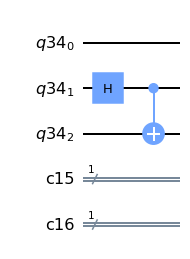

In [58]:
def entanglement_bell_pair(qc, a, b):
    
    qc.h(a) # Put qubit a into state |+> or |-> using hadamard gate
    qc.cx(a,b) # CNOT with a as control and b as target

#  Eve entangles qubits q1 and q2

entanglement_bell_pair(teleportation_circuit, 1, 2)
teleportation_circuit.draw(output='mpl')

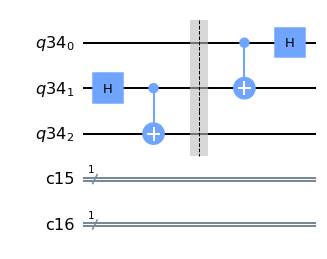

In [59]:
def alice_state_qubits(qc, psi, a):
    qc.cx(psi, a) #psi is the state of q0
    qc.h(psi)
    
# call the function to our circuit
teleportation_circuit.barrier()
alice_state_qubits(teleportation_circuit, 0, 1)
teleportation_circuit.draw(output='mpl')

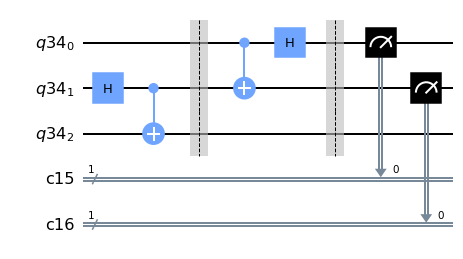

In [60]:
def measure_classical_send(qc, a, b):
    
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)

measure_classical_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw(output='mpl')

In [61]:
#based on cr1 and cr2 which store the classical bits
def bob_apply_gates(qc, qubit, cr1, cr2):

    qc.z(qubit).c_if(cr1, 1)  #if cr1 is 1 apply Z gate
    qc.x(qubit).c_if(cr2, 1) #if cr2 is 1 apply x gate, look at table above

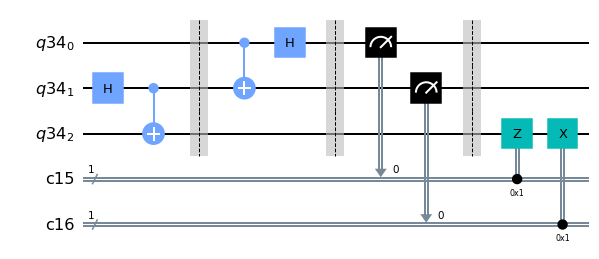

In [62]:
# Let's apply this to our circuit:
teleportation_circuit.barrier() # Use barrier to separate steps
bob_apply_gates(teleportation_circuit, 2, cr1, cr2)
teleportation_circuit.draw(output='mpl')

In [63]:
def random_state(nqubits):
    """Creates a random nqubit state vector"""
    from numpy import append, array, sqrt
    from numpy.random import random
    real_parts = array([])
    im_parts = array([])
    for amplitude in range(2**nqubits):
        real_parts = append(real_parts, (random()*2)-1)
        im_parts = append(im_parts, (random()*2)-1)
    # Combine into list of complex numbers:
    amps = real_parts + 1j*im_parts
    # Normalise
    magnitude_squared = 0
    for a in amps:
        magnitude_squared += abs(a)**2
    amps /= sqrt(magnitude_squared)
    return amps
# specify a random state

psi = random_state(1)

In [64]:
from qiskit.extensions import Initialize
init_gate = Initialize(psi)

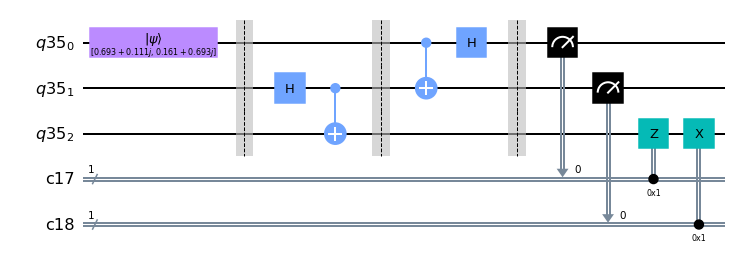

In [65]:
qr = QuantumRegister(3)   
cr1 = ClassicalRegister(1) 
cr2 = ClassicalRegister(1)
qc = QuantumCircuit(qr, cr1, cr2)

#let's initialise Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# teleportation protocol
entanglement_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_state_qubits(qc, 0, 1)

# alice sends to Bob
measure_classical_send(qc, 0, 1)

# Bob decodes qubits
bob_apply_gates(qc, 2, cr1, cr2)

qc.draw(output='mpl')

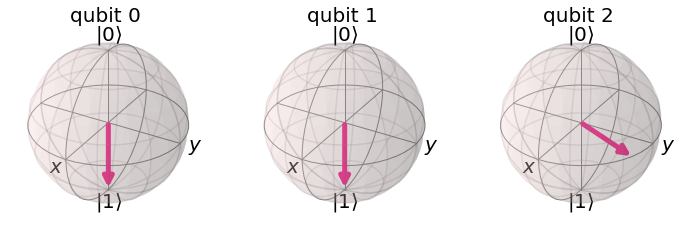

In [66]:
backend = BasicAer.get_backend('statevector_simulator')
out_vector = execute(qc, backend).result().get_statevector()
plot_bloch_multivector(out_vector)

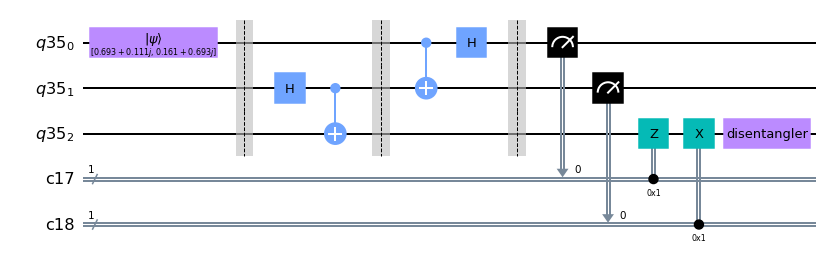

In [67]:
inverse_init_gate = init_gate.gates_to_uncompute()
qc.append(inverse_init_gate, [2])
qc.draw(output='mpl')

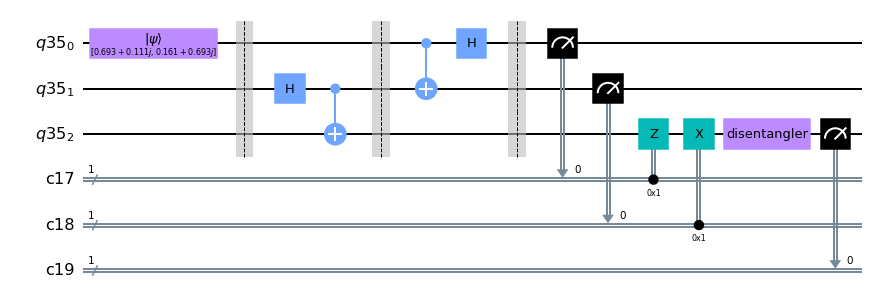

In [68]:
#add a new classical register to see the result
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw(output='mpl')

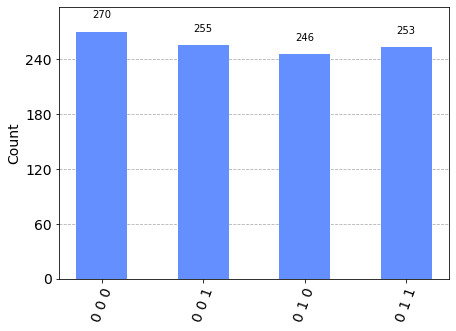

In [69]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)